# 🔬 ABC2026 CHALLENGE - DEEP EDA & FEATURE ENGINEERING
---
**Notebook này tập trung vào phân tích chuyên sâu (Deep EDA) và xử lý dữ liệu (Feature Engineering) cho bài toán định vị trong nhà (Indoor Localization) dựa trên BLE.**

### 🎯 Mục tiêu:
1.  **Data Loading & Alignment**: Load dữ liệu từ local, đồng bộ thời gian giữa BLE và Label.
2.  **Deep EDA (Raw Data)**:
    *   Phân tích mất cân bằng lớp (Class Imbalance) & Lorenz Curve.
    *   Đánh giá độ phủ (Coverage) và độ tin cậy (Reliability) của từng Beacon.
    *   Phân tích chất lượng tín hiệu (SNR, Stability Index).
3.  **Feature Engineering**:
    *   Áp dụng Sliding Window để khử nhiễu và xử lý dữ liệu thưa (Sparsity).
4.  **Deep EDA (Features)**:
    *   Phân tích tương quan (Correlation) giữa các Beacons.
    *   Đánh giá khả năng phân tách lớp (Separability) bằng PCA và t-SNE.

### 📂 Cấu trúc dữ liệu:
*   **Input**: `E:\project\ABC2026\ABC2026 Sozolab Challenge\Dataset`
*   **Output**: Các biểu đồ phân tích và file summary JSON.

In [1]:
# Cell 1: Setup & Data Loading (Colab-ready)
# Tải data.zip từ link cung cấp và giải nén để có cấu trúc như local.

import os
from pathlib import Path
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# --- CONFIGURATION ---
DATA_URL = "https://bkuteam.site/data.zip"
BASE_DIR = Path("/content/ABC2026")
ZIP_PATH = BASE_DIR / "data.zip"
BASE_DIR.mkdir(parents=True, exist_ok=True)

DATA_ROOT = BASE_DIR / "ABC2026 Sozolab Challenge"
DATASET_DIR = DATA_ROOT / "Dataset"
DATA_READY = DATASET_DIR.exists() and any(DATASET_DIR.glob("*.csv"))

if DATA_READY:
    print("Data đã có sẵn, bỏ qua bước tải.")
else:
    print("Downloading data.zip...")
    resp = requests.get(DATA_URL, stream=True)
    resp.raise_for_status()
    with open(ZIP_PATH, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(BASE_DIR)
    DATA_READY = DATASET_DIR.exists() and any(DATASET_DIR.glob("*.csv"))
    if DATA_READY:
        print("Giải nén xong, dữ liệu sẵn sàng.")
    else:
        raise FileNotFoundError("Giải nén xong nhưng không thấy file CSV trong Dataset.")

DATA_PATH = str(DATASET_DIR)
OUTPUT_PATH = str(DATA_ROOT)

# Mapping 25 Beacons
MAC_LIST = [
    'F7:7F:78:76:7E:F3', 'C6:CD:5E:3D:2F:BB', 'D6:F4:3A:79:74:63', 'C9:17:55:E2:3E:0E', 'CA:60:AB:EE:EC:7F',
    'D6:51:7F:AB:0E:29', 'CC:54:33:F6:A7:90', 'EB:20:56:87:04:5A', 'EE:E7:46:DC:19:6F', 'C8:5B:BF:37:07:A0',
    'D7:26:F6:A3:44:D2', 'DD:83:B0:27:FD:36', 'E5:CD:4A:36:87:06', 'DC:22:B8:17:4E:B5', 'EA:09:20:80:D6:44',
    'E6:99:D1:EC:C6:81', 'F6:DA:97:C7:D5:28', 'EA:66:A1:12:2C:F4', 'C9:EA:57:8B:0F:80', 'D6:7C:1D:2C:2A:0A',
    'DA:E1:70:5F:44:97', 'DD:10:10:F6:4F:27', 'E6:F3:93:A8:9E:22', 'E6:60:05:1F:88:F9', 'D4:33:FD:F4:C2:A8'
]
BEACON_IDS = [str(i) for i in range(1, 26)]
MAC_TO_BEACON = dict(zip(MAC_LIST, BEACON_IDS))

print(f"Data Path: {DATA_PATH}")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Path not found: {DATA_PATH}")

Extracting...
Giải nén xong, dữ liệu sẵn sàng.
Data Path: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset


In [2]:
# Cell 1b: Plot logging helper (đặt tên + lưu metadata cho mỗi biểu đồ)
# Quy tắc: mọi biểu đồ phải đặt tên, log tham số và in thông tin đầu vào.
PLOT_REGISTRY = []
PLOT_META_PATH = os.path.join(OUTPUT_PATH, "plot_metadata.json")


def log_plot(name: str, description: str = "", params: dict | None = None, data_notes: dict | None = None):
    """Ghi log metadata cho biểu đồ, in ra và lưu JSON đơn giản."""
    meta = {
        "name": name,
        "description": description,
        "params": params or {},
        "data_notes": data_notes or {},
        "timestamp": pd.Timestamp.now().isoformat(),
    }
    PLOT_REGISTRY.append(meta)
    print(f"[PLOT LOG] {name}")
    print(json.dumps(meta, indent=2, ensure_ascii=False))
    try:
        with open(PLOT_META_PATH, "w", encoding="utf-8") as f:
            json.dump(PLOT_REGISTRY, f, ensure_ascii=False, indent=2)
        print(f"[PLOT LOG] Đã lưu: {PLOT_META_PATH}")
    except Exception as e:
        print(f"[CẢNH BÁO] Không lưu được plot metadata: {e}")


In [3]:
# Cell 2: Load Files & Align Data
# Load BLE (User 90) and Label (User 97 Location)

# 1. Find Files
ble_files = []
label_file = None
ble_folder = os.path.join(DATA_PATH, "BLE Data")

if os.path.exists(ble_folder):
    for f in os.listdir(ble_folder):
        if f.endswith(".csv") and "user-ble-id_90" in f:
            ble_files.append(os.path.join(ble_folder, f))

for f in os.listdir(DATA_PATH):
    if "label" in f.lower() and "train" in f.lower() and f.endswith(".csv"):
        label_file = os.path.join(DATA_PATH, f)

if not ble_files:
    raise ValueError("No BLE files found.")
if not label_file:
    raise ValueError("No Label file found.")

print(f"Found {len(ble_files)} BLE files and Label file: {os.path.basename(label_file)}")

# 2. Load BLE
ble_dfs = []
for f in tqdm(ble_files, desc="Loading BLE"):
    try:
        df = pd.read_csv(f, header=None, names=['user_id', 'timestamp', 'scan_content', 'mac address', 'RSSI', 'tx_power'])
        df = df[df['mac address'].isin(MAC_LIST)].copy()
        if not df.empty:
            df['beacon_id'] = df['mac address'].map(MAC_TO_BEACON)
            ble_dfs.append(df[['timestamp', 'beacon_id', 'RSSI']])
    except:
        pass

df_ble = pd.concat(ble_dfs, ignore_index=True)
df_ble['datetime'] = pd.to_datetime(df_ble['timestamp'], utc=True).dt.tz_convert('Asia/Tokyo')
df_ble = df_ble.sort_values('datetime')

# 3. Load Label
df_lbl = pd.read_csv(label_file)
df_lbl = df_lbl[(df_lbl['user_id'] == 97) & (df_lbl['activity'] == 'Location')].copy()
for col in ['started_at', 'finished_at']:
    df_lbl[col] = pd.to_datetime(df_lbl[col])
    if df_lbl[col].dt.tz is None:
        df_lbl[col] = df_lbl[col].dt.tz_localize('Asia/Tokyo')
    else:
        df_lbl[col] = df_lbl[col].dt.tz_convert('Asia/Tokyo')
df_lbl = df_lbl.sort_values('started_at')

# 4. Align
print("Aligning Data...")
labeled_data = []
for _, row in tqdm(df_lbl.iterrows(), total=len(df_lbl), desc="Aligning"):
    mask = (df_ble['datetime'] >= row['started_at']) & (df_ble['datetime'] <= row['finished_at'])
    subset = df_ble[mask].copy()
    if not subset.empty:
        subset['location'] = row['room']
        labeled_data.append(subset)

if labeled_data:
    df_final = pd.concat(labeled_data, ignore_index=True)

    raw_summary = {
        'total_samples': len(df_final),
        'time_range': {'start': str(df_final['datetime'].min()), 'end': str(df_final['datetime'].max())},
        'num_locations': int(df_final['location'].nunique()),
        'num_beacons': int(df_final['beacon_id'].nunique()),
        'locations': df_final['location'].value_counts().to_dict()
    }
    with open(os.path.join(OUTPUT_PATH, 'data_summary_raw.json'), 'w', encoding='utf-8') as f:
        json.dump(raw_summary, f, indent=2, ensure_ascii=False)

    print(f"Raw Dataset Shape: {df_final.shape}")
    print(f"   Time Range: {df_final['datetime'].min()} -> {df_final['datetime'].max()}")
    print(f"   Locations: {df_final['location'].nunique()}")
    print("   Saved: data_summary_raw.json")
    display(df_final.head())
else:
    raise ValueError("Alignment failed.")

Found 4107 BLE files and Label file: 5f_label_loc_train.csv


Loading BLE: 100%|██████████| 4107/4107 [00:16<00:00, 256.13it/s]


Aligning Data...


Aligning: 100%|██████████| 459/459 [00:05<00:00, 77.39it/s]


Raw Dataset Shape: (1117361, 5)
   Time Range: 2023-04-10 14:21:46.003000+09:00 -> 2023-04-13 12:48:16.419000+09:00
   Locations: 22
   Saved: data_summary_raw.json


,timestamp,beacon_id,RSSI,datetime,location
0,2023-04-10T14:21:46.003+0900,4,-90,2023-04-10 14:21:46.003000+09:00,kitchen
1,2023-04-10T14:21:46.008+0900,4,-90,2023-04-10 14:21:46.008000+09:00,kitchen
2,2023-04-10T14:21:46.012+0900,4,-90,2023-04-10 14:21:46.012000+09:00,kitchen
3,2023-04-10T14:21:46.018+0900,4,-90,2023-04-10 14:21:46.018000+09:00,kitchen
4,2023-04-10T14:21:46.024+0900,4,-90,2023-04-10 14:21:46.024000+09:00,kitchen


In [4]:
# Cell 3: Data Prep for EDA (no plots)
# Tính toán trước: phân bố mẫu, lorenz, độ phủ, fingerprint, reliability.

if 'df_final' in locals():
    # Counts
    loc_counts = df_final['location'].value_counts().sort_values(ascending=False)
    beacon_counts = df_final['beacon_id'].value_counts().sort_index()

    # Sparsity matrix (coverage % per location-beacon)
    sparsity_data = []
    for loc in df_final['location'].unique():
        df_loc = df_final[df_final['location'] == loc]
        total = len(df_loc)
        for b in BEACON_IDS:
            cnt = (df_loc['beacon_id'] == b).sum()
            coverage = (cnt / total * 100) if total > 0 else 0
            sparsity_data.append({'location': loc, 'beacon_id': b, 'coverage_pct': coverage})
    df_sparsity = pd.DataFrame(sparsity_data)
    sparsity_pivot = df_sparsity.pivot(index='location', columns='beacon_id', values='coverage_pct')
    sparsity_pivot = sparsity_pivot[sorted(sparsity_pivot.columns, key=lambda x: int(x))]

    # RSSI fingerprint
    rssi_pivot = df_final.pivot_table(index='location', columns='beacon_id', values='RSSI', aggfunc='mean')
    rssi_pivot = rssi_pivot[sorted(rssi_pivot.columns, key=lambda x: int(x))]
    rssi_std_pivot = df_final.pivot_table(index='location', columns='beacon_id', values='RSSI', aggfunc='std')
    rssi_std_pivot = rssi_std_pivot[sorted(rssi_std_pivot.columns, key=lambda x: int(x))]

    # Reliability
    reliability_rows = []
    for b in BEACON_IDS:
        avg_cov = sparsity_pivot[b].mean()
        avg_rssi = df_final[df_final['beacon_id'] == b]['RSSI'].mean()
        rssi_norm = ((avg_rssi + 100) / 70) * 100 if avg_rssi > -100 else 0
        score = (avg_cov + rssi_norm) / 2
        reliability_rows.append({'beacon_id': b, 'reliability_score': score, 'coverage_pct': avg_cov, 'avg_rssi': avg_rssi})
    df_reliability = pd.DataFrame(reliability_rows).sort_values('reliability_score', ascending=False)

    # Lorenz/Gini
    loc_sorted = loc_counts.sort_values()
    cumsum = np.cumsum(loc_sorted.values)
    lorenz_y = cumsum / cumsum[-1]
    lorenz_x = np.arange(1, len(lorenz_y) + 1) / len(lorenz_y)
    gini_coeff = 1 - 2 * np.trapz(lorenz_y, lorenz_x)

    # Print key numbers for downstream plots
    print("DATA PREP SUMMARY")
    print(f"Samples: {len(df_final):,}; Locations: {df_final['location'].nunique()}; Beacons seen: {df_final['beacon_id'].nunique()}/25")
    print(f"Max/Min samples per location: {loc_counts.max():,} / {loc_counts.min():,}; Ratio: {loc_counts.max()/loc_counts.min():.2f}x")
    print(f"Gini: {gini_coeff:.3f}")
    print(f"Coverage <10% beacons: {(df_reliability['coverage_pct'] < 10).sum()}/25")
    print(f"Zero-coverage pairs: {(sparsity_pivot == 0).sum().sum()} of {sparsity_pivot.size}")
else:
    print("Run Cell 2 first.")

DATA PREP SUMMARY
Samples: 1,117,361; Locations: 22; Beacons seen: 23/25
Max/Min samples per location: 538,553 / 645; Ratio: 834.97x
Gini: 0.806
Coverage <10% beacons: 25/25
Zero-coverage pairs: 249 of 550


Params: {'loc_count_max': 538553, 'loc_count_min': 645, 'locations': 22, 'mean': 50789.13636363636}
[PLOT LOG] Location Sample Distribution
{
  "name": "Location Sample Distribution",
  "description": "Phân bố mẫu theo location (đánh giá imbalance)",
  "params": {
    "loc_count_max": 538553,
    "loc_count_min": 645,
    "locations": 22,
    "mean": 50789.13636363636
  },
  "data_notes": {
    "top5_locations": {
      "nurse station": 538553,
      "cafeteria": 198877,
      "kitchen": 167730,
      "hallway": 65279,
      "523": 34405
    },
    "bottom5_locations": {
      "503": 1534,
      "517": 1459,
      "510": 734,
      "518": 654,
      "505": 645
    }
  },
  "timestamp": "2025-12-09T15:00:31.669628"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


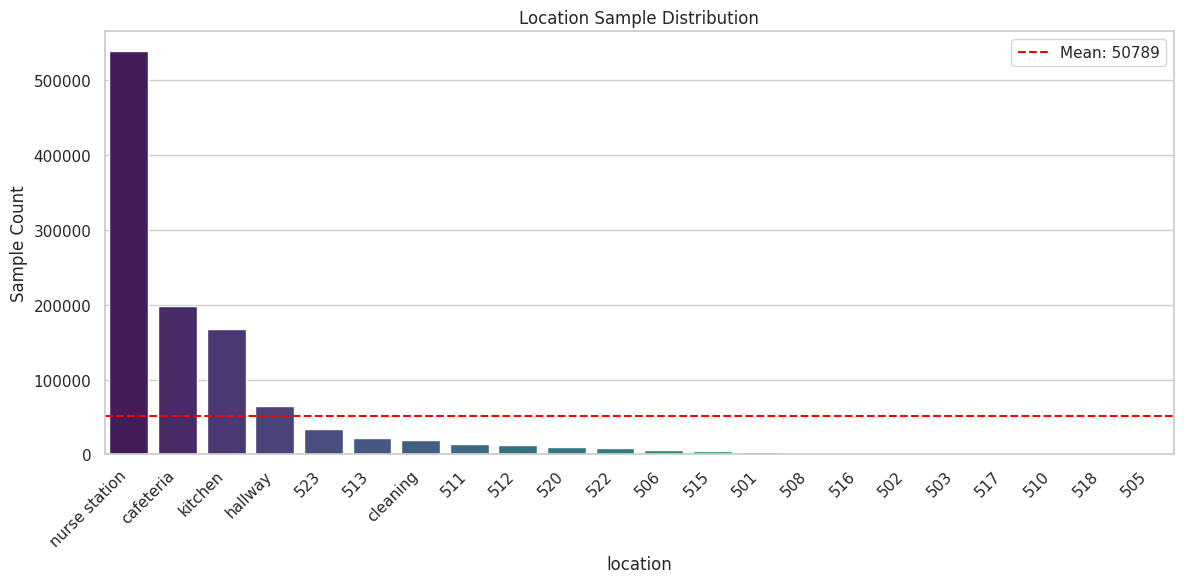

In [5]:
# Cell 4: Plot - Location Sample Distribution (Class Imbalance)
if 'loc_counts' in globals():
    plot_name = "Location Sample Distribution"
    plot_params = {
        "loc_count_max": int(loc_counts.max()),
        "loc_count_min": int(loc_counts.min()),
        "locations": int(len(loc_counts)),
        "mean": float(loc_counts.mean()),
    }
    data_notes = {
        "top5_locations": {k: int(v) for k, v in loc_counts.head(5).to_dict().items()},
        "bottom5_locations": {k: int(v) for k, v in loc_counts.tail(5).to_dict().items()},
    }
    print("Params:", plot_params)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=loc_counts.index, y=loc_counts.values, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title(plot_name)
    plt.ylabel("Sample Count")
    plt.axhline(loc_counts.mean(), color='red', linestyle='--', label=f"Mean: {loc_counts.mean():.0f}")
    plt.legend()
    plt.gcf().subplots_adjust(bottom=0.28)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Phân bố mẫu theo location (đánh giá imbalance)",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'gini': 0.8056624655611018, 'points': 22}
[PLOT LOG] Lorenz Curve (Gini=0.806)
{
  "name": "Lorenz Curve (Gini=0.806)",
  "description": "Độ mất cân bằng mẫu qua đường Lorenz",
  "params": {
    "gini": 0.8056624655611018,
    "points": 22
  },
  "data_notes": {
    "lorenz_start": 0.0005772530095466014,
    "lorenz_end": 1.0
  },
  "timestamp": "2025-12-09T15:00:32.213615"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


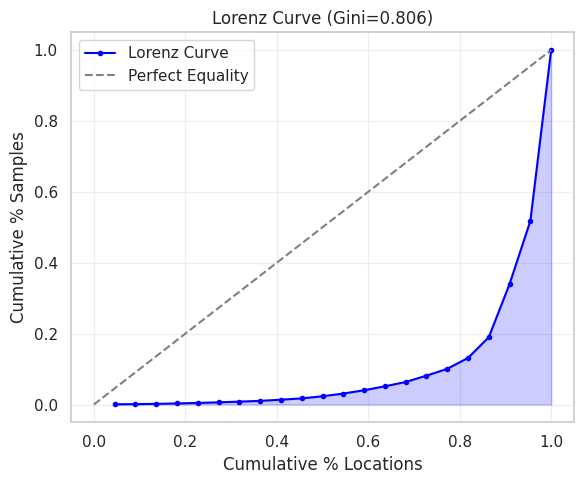

In [6]:
# Cell 5: Plot - Lorenz Curve (Class Imbalance)
if 'lorenz_x' in globals() and 'lorenz_y' in globals():
    plot_name = f"Lorenz Curve (Gini={gini_coeff:.3f})"
    plot_params = {"gini": float(gini_coeff), "points": int(len(lorenz_x))}
    data_notes = {
        "lorenz_start": float(lorenz_y[0]) if len(lorenz_y) > 0 else None,
        "lorenz_end": float(lorenz_y[-1]) if len(lorenz_y) > 0 else None,
    }
    print("Params:", plot_params)
    plt.figure(figsize=(6, 5))
    plt.plot(lorenz_x, lorenz_y, marker='o', markersize=3, label='Lorenz Curve', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Equality')
    plt.fill_between(lorenz_x, lorenz_y, alpha=0.2, color='blue')
    plt.xlabel("Cumulative % Locations")
    plt.ylabel("Cumulative % Samples")
    plt.title(plot_name)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Độ mất cân bằng mẫu qua đường Lorenz",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'top5': [10.08, 8.48, 8.05, 8.02, 7.88], 'bottom5': [5.46, 5.43, 5.33, 0.0, 0.0], 'coverage_mean': 4.0}
[PLOT LOG] Beacon Reliability Score
{
  "name": "Beacon Reliability Score",
  "description": "Chỉ số độ tin cậy beacon (coverage + RSSI)",
  "params": {
    "top5": [
      10.08,
      8.48,
      8.05,
      8.02,
      7.88
    ],
    "bottom5": [
      5.46,
      5.43,
      5.33,
      0.0,
      0.0
    ],
    "coverage_mean": 4.0
  },
  "data_notes": {
    "best_beacon": "20",
    "best_score": 10.082401354047677,
    "worst_beacon": "25",
    "worst_score": 0.0
  },
  "timestamp": "2025-12-09T15:00:32.633502"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


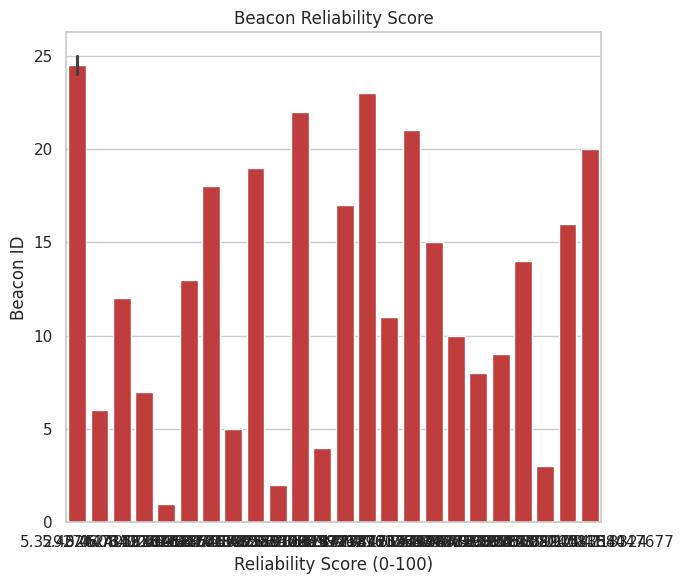

In [7]:
# Cell 6: Plot - Beacon Reliability Score
if 'df_reliability' in globals():
    plot_name = "Beacon Reliability Score"
    top5_scores = df_reliability['reliability_score'].head(5).round(2).tolist()
    bottom5_scores = df_reliability['reliability_score'].tail(5).round(2).tolist()
    plot_params = {
        "top5": top5_scores,
        "bottom5": bottom5_scores,
        "coverage_mean": float(df_reliability['coverage_pct'].mean()),
    }
    data_notes = {
        "best_beacon": str(df_reliability.iloc[0]['beacon_id']),
        "best_score": float(df_reliability.iloc[0]['reliability_score']),
        "worst_beacon": str(df_reliability.iloc[-1]['beacon_id']),
        "worst_score": float(df_reliability.iloc[-1]['reliability_score']),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(7, 6))
    sns.barplot(y=df_reliability['beacon_id'].astype(int), x=df_reliability['reliability_score'], color='tab:red')
    plt.xlabel("Reliability Score (0-100)")
    plt.ylabel("Beacon ID")
    plt.title(plot_name)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Chỉ số độ tin cậy beacon (coverage + RSSI)",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'coverage_mean_pct': 4.0, 'zero_pairs': 249, 'total_pairs': 550}
[PLOT LOG] Beacon Coverage by Location (%)
{
  "name": "Beacon Coverage by Location (%)",
  "description": "Heatmap độ phủ beacon theo location (tỷ lệ % mẫu)",
  "params": {
    "coverage_mean_pct": 4.0,
    "zero_pairs": 249,
    "total_pairs": 550
  },
  "data_notes": {
    "coverage_mean_by_location": {
      "501": 4.0,
      "502": 4.0,
      "503": 4.0,
      "505": 4.0,
      "506": 4.0
    }
  },
  "timestamp": "2025-12-09T15:00:33.233858"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


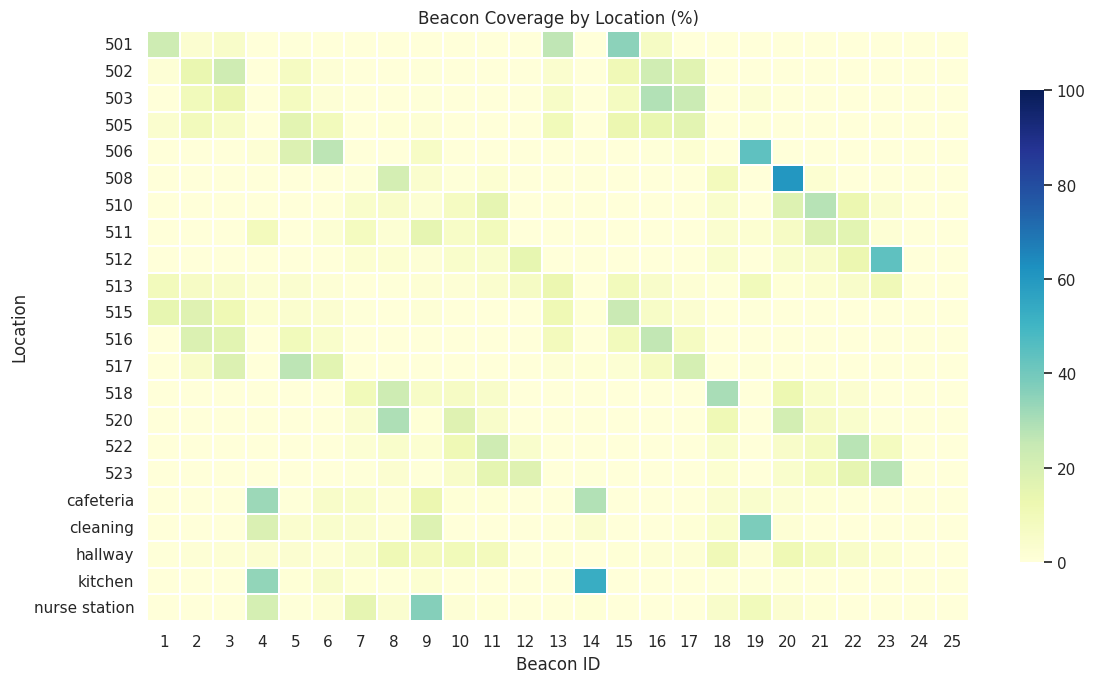

In [8]:
# Cell 7: Plot - Beacon Coverage Heatmap (% of samples)
if 'sparsity_pivot' in globals():
    plot_name = "Beacon Coverage by Location (%)"
    coverage_mean = float(sparsity_pivot.mean(axis=1).mean())
    zero_pairs = int((sparsity_pivot == 0).sum().sum())
    total_pairs = int(sparsity_pivot.size)
    plot_params = {"coverage_mean_pct": coverage_mean, "zero_pairs": zero_pairs, "total_pairs": total_pairs}
    data_notes = {
        "coverage_mean_by_location": sparsity_pivot.mean(axis=1).round(2).head(5).to_dict(),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(12, 7))
    sns.heatmap(sparsity_pivot, cmap="YlGnBu", vmin=0, vmax=100, linewidths=0.3, linecolor='white', cbar_kws={"shrink": 0.8})
    plt.xlabel("Beacon ID")
    plt.ylabel("Location")
    plt.title(plot_name)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Heatmap độ phủ beacon theo location (tỷ lệ % mẫu)",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'rssi_mean': -93.06368129906092, 'rssi_std': 4.202928009064007}
[PLOT LOG] Mean RSSI by Location-Beacon
{
  "name": "Mean RSSI by Location-Beacon",
  "description": "Fingerprint RSSI trung bình theo location-beacon",
  "params": {
    "rssi_mean": -93.06368129906092,
    "rssi_std": 4.202928009064007
  },
  "data_notes": {
    "locations_sample": {
      "501": -94.79,
      "502": -93.66,
      "503": -93.59
    }
  },
  "timestamp": "2025-12-09T15:00:33.774887"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


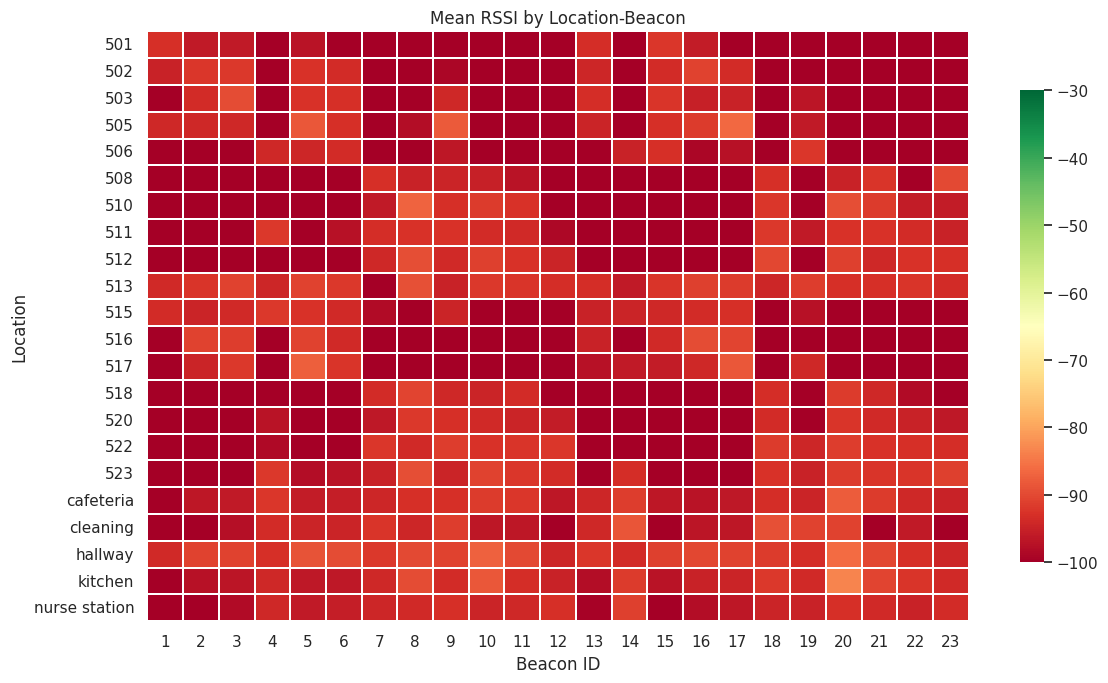

In [9]:
# Cell 8: Plot - Mean RSSI Fingerprint
if 'rssi_pivot' in globals():
    plot_name = "Mean RSSI by Location-Beacon"
    plot_params = {
        "rssi_mean": float(df_final['RSSI'].mean()),
        "rssi_std": float(df_final['RSSI'].std()),
    }
    data_notes = {
        "locations_sample": rssi_pivot.head(3).mean(axis=1).round(2).to_dict(),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(12, 7))
    sns.heatmap(rssi_pivot.fillna(-100), cmap="RdYlGn", vmin=-100, vmax=-30, linewidths=0.3, linecolor='white', cbar_kws={"shrink": 0.8})
    plt.xlabel("Beacon ID")
    plt.ylabel("Location")
    plt.title(plot_name)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Fingerprint RSSI trung bình theo location-beacon",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'min_std': 2.290856505051425, 'min_loc': '506', 'max_std': 4.433368555046786, 'max_loc': 'hallway'}
[PLOT LOG] RSSI Std Dev by Location-Beacon
{
  "name": "RSSI Std Dev by Location-Beacon",
  "description": "Độ ổn định RSSI (độ lệch chuẩn) theo location-beacon",
  "params": {
    "min_std": 2.290856505051425,
    "min_loc": "506",
    "max_std": 4.433368555046786,
    "max_loc": "hallway"
  },
  "data_notes": {
    "sample_std_by_location": {
      "501": 2.62,
      "502": 3.38,
      "503": 3.23,
      "505": 2.96,
      "506": 2.29
    }
  },
  "timestamp": "2025-12-09T15:00:34.349882"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


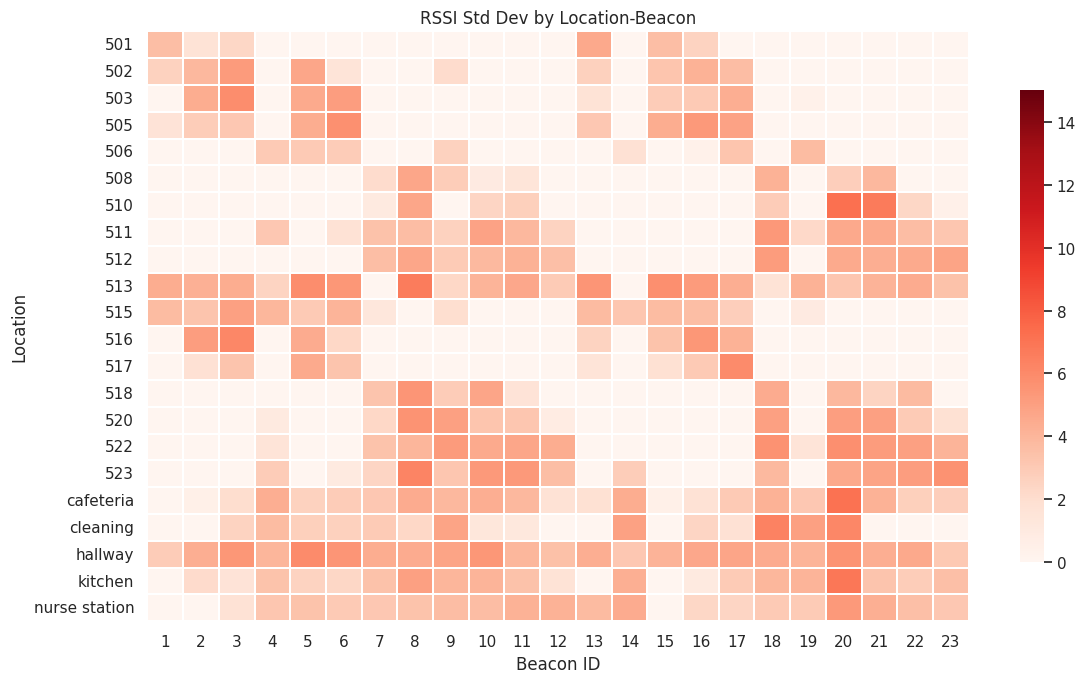

In [10]:
# Cell 9: Plot - RSSI Stability (Std Dev)
if 'rssi_std_pivot' in globals():
    mean_std = rssi_std_pivot.mean(axis=1)
    plot_name = "RSSI Std Dev by Location-Beacon"
    plot_params = {
        "min_std": float(mean_std.min()),
        "min_loc": mean_std.idxmin(),
        "max_std": float(mean_std.max()),
        "max_loc": mean_std.idxmax(),
    }
    data_notes = {
        "sample_std_by_location": mean_std.head(5).round(2).to_dict(),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(12, 7))
    sns.heatmap(rssi_std_pivot.fillna(0), cmap="Reds", vmin=0, vmax=15, linewidths=0.3, linecolor='white', cbar_kws={"shrink": 0.8})
    plt.xlabel("Beacon ID")
    plt.ylabel("Location")
    plt.title(plot_name)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Độ ổn định RSSI (độ lệch chuẩn) theo location-beacon",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'median_freq': 21609.0, 'max_freq': 241100, 'min_freq': 3680}
[PLOT LOG] Beacon Detection Frequency
{
  "name": "Beacon Detection Frequency",
  "description": "Tần suất phát hiện beacon",
  "params": {
    "median_freq": 21609.0,
    "max_freq": 241100,
    "min_freq": 3680
  },
  "data_notes": {
    "top5_beacons": {
      "1": 3778,
      "10": 21609,
      "11": 23010,
      "12": 10704,
      "13": 5402
    }
  },
  "timestamp": "2025-12-09T15:00:34.811393"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


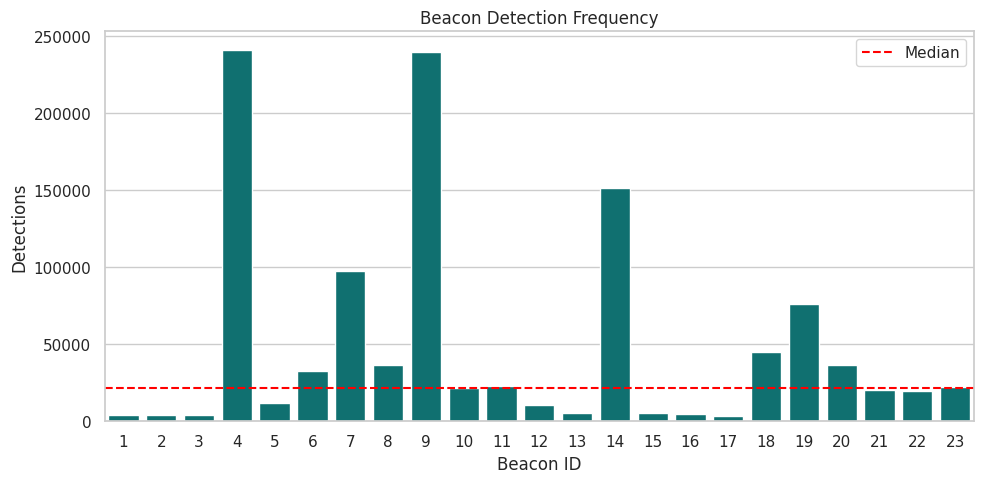

In [11]:
# Cell 10: Plot - Beacon Detection Frequency
if 'beacon_counts' in globals():
    plot_name = "Beacon Detection Frequency"
    plot_params = {
        "median_freq": float(beacon_counts.median()),
        "max_freq": int(beacon_counts.max()),
        "min_freq": int(beacon_counts.min()),
    }
    data_notes = {
        "top5_beacons": {int(k): int(v) for k, v in beacon_counts.head(5).to_dict().items()},
    }
    print("Params:", plot_params)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=beacon_counts.index.astype(int), y=beacon_counts.values, color='teal')
    plt.axhline(beacon_counts.median(), color='red', linestyle='--', label='Median')
    plt.xlabel("Beacon ID")
    plt.ylabel("Detections")
    plt.title(plot_name)
    plt.legend()
    plt.gcf().subplots_adjust(bottom=0.18)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Tần suất phát hiện beacon",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

Params: {'top_location': 'nurse station', 'top_share_pct': 48.19865737214741, 'n_locations': 22}
[PLOT LOG] Sample Distribution (Top 10)
{
  "name": "Sample Distribution (Top 10)",
  "description": "Tỷ lệ mẫu top 10 location",
  "params": {
    "top_location": "nurse station",
    "top_share_pct": 48.19865737214741,
    "n_locations": 22
  },
  "data_notes": {
    "top10_counts": {
      "nurse station": 538553,
      "cafeteria": 198877,
      "kitchen": 167730,
      "hallway": 65279,
      "523": 34405,
      "513": 21494,
      "cleaning": 19977,
      "511": 13639,
      "512": 12362,
      "520": 10480
    },
    "others": 34565
  },
  "timestamp": "2025-12-09T15:00:35.166658"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


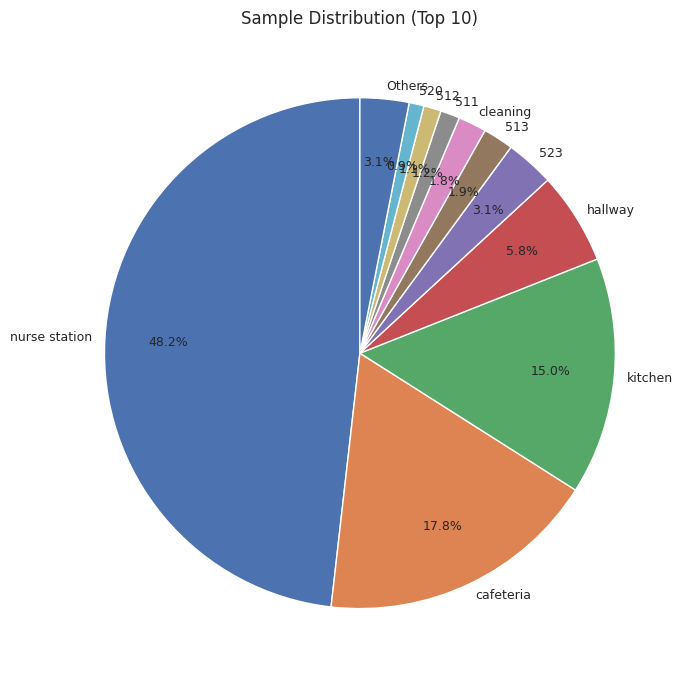

In [12]:
# Cell 11: Plot - Sample Distribution Pie (Top 10 Locations)
if 'loc_counts' in globals():
    top10 = loc_counts.head(10)
    other = loc_counts[10:].sum() if len(loc_counts) > 10 else 0
    if other > 0:
        pie_data = pd.concat([top10, pd.Series({'Others': other})])
    else:
        pie_data = top10
    plot_name = "Sample Distribution (Top 10)"
    plot_params = {
        "top_location": loc_counts.idxmax(),
        "top_share_pct": float(loc_counts.max()/loc_counts.sum()*100),
        "n_locations": int(len(loc_counts)),
    }
    data_notes = {
        "top10_counts": {k: int(v) for k, v in top10.to_dict().items()},
        "others": int(other),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(7, 7))
    plt.pie(
        pie_data.values,
        labels=pie_data.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 9},
        pctdistance=0.75,
        labeldistance=1.05,
    )
    plt.title(plot_name)
    plt.axis('equal')
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Tỷ lệ mẫu top 10 location",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 3 first.")

In [13]:
# Cell 12: Signal Quality Prep (select target and compute stats)
if 'df_final' in locals():
    TARGET_LOC = df_final['location'].value_counts().idxmax()
    df_loc = df_final[df_final['location'] == TARGET_LOC]
    TARGET_BEACON = df_loc['beacon_id'].value_counts().idxmax()

    subset = df_loc[df_loc['beacon_id'] == TARGET_BEACON].copy().sort_values('datetime')
    subset['time_diff'] = subset['datetime'].diff().dt.total_seconds()
    gaps = subset['time_diff'].dropna()

    snr_score = abs(subset['RSSI'].mean()) / subset['RSSI'].std() if subset['RSSI'].std() > 0 else 0
    cv = subset['RSSI'].std() / abs(subset['RSSI'].mean()) if subset['RSSI'].mean() != 0 else np.inf
    stability_index = 1 / cv if cv > 0 else 0

    top_locs_for_beacon = df_final[df_final['beacon_id'] == TARGET_BEACON]['location'].value_counts().head(5).index
    subset_multi = df_final[(df_final['location'].isin(top_locs_for_beacon)) & (df_final['beacon_id'] == TARGET_BEACON)]

    loc_stats = []
    for loc in top_locs_for_beacon:
        loc_data = subset_multi[subset_multi['location'] == loc]['RSSI']
        loc_stats.append({
            'location': loc,
            'mean_rssi': loc_data.mean(),
            'std_rssi': loc_data.std(),
            'snr': abs(loc_data.mean()) / loc_data.std() if loc_data.std() > 0 else 0,
            'count': len(loc_data)
        })
    df_loc_stats = pd.DataFrame(loc_stats).sort_values('snr', ascending=False)

    print("SIGNAL PREP")
    print(f"Target location={TARGET_LOC}, beacon={TARGET_BEACON}")
    print(f"SNR={snr_score:.2f}, CV={cv:.3f}, StabilityIndex={stability_index:.2f}, Samples={len(subset):,}")
    print(f"Gaps>10s: {len(gaps[gaps > 10])}/{len(gaps)}")
else:
    print("Run Cell 2 first.")

SIGNAL PREP
Target location=nurse station, beacon=9
SNR=25.19, CV=0.040, StabilityIndex=25.19, Samples=196,245
Gaps>10s: 131/196244


Params: {'mean': -92.91227801982217, 'std': 3.6889302579064447, 'samples': 196245}
[PLOT LOG] RSSI Time Series (Loc nurse station, Beacon 9)
{
  "name": "RSSI Time Series (Loc nurse station, Beacon 9)",
  "description": "RSSI theo thời gian cho location/beacon tiêu biểu",
  "params": {
    "mean": -92.91227801982217,
    "std": 3.6889302579064447,
    "samples": 196245
  },
  "data_notes": {
    "time_start": "2023-04-10 14:23:42.036000+09:00",
    "time_end": "2023-04-13 12:48:16.419000+09:00"
  },
  "timestamp": "2025-12-09T15:00:43.112507"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


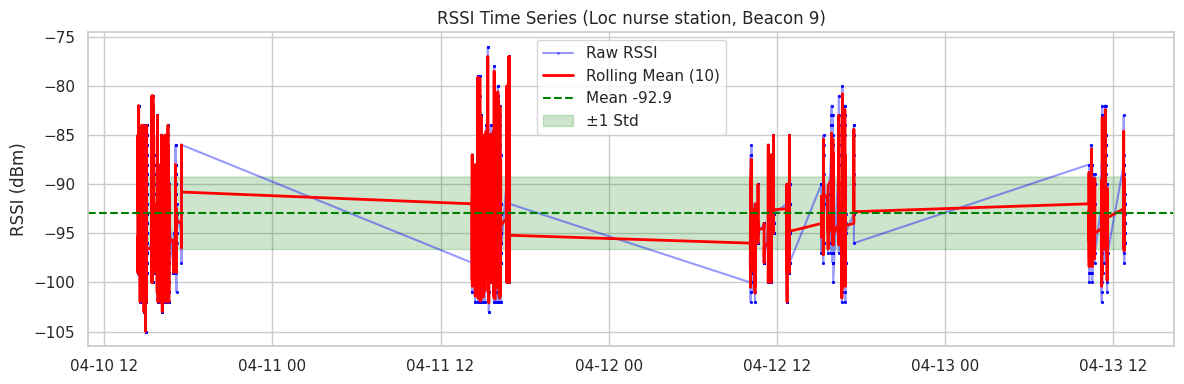

In [14]:
# Cell 13: Plot - RSSI Time Series (Target location/beacon)
if 'subset' in globals():
    plot_name = f"RSSI Time Series (Loc {TARGET_LOC}, Beacon {TARGET_BEACON})"
    plot_params = {
        "mean": float(subset['RSSI'].mean()),
        "std": float(subset['RSSI'].std()),
        "samples": int(len(subset)),
    }
    data_notes = {
        "time_start": str(subset['datetime'].min()),
        "time_end": str(subset['datetime'].max()),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(12, 4))
    plt.plot(subset['datetime'], subset['RSSI'], marker='o', linestyle='-', markersize=1, alpha=0.4, color='blue', label='Raw RSSI')
    subset['rssi_smooth'] = subset['RSSI'].rolling(window=10, center=True).mean()
    plt.plot(subset['datetime'], subset['rssi_smooth'], color='red', linewidth=2, label='Rolling Mean (10)')
    plt.axhline(subset['RSSI'].mean(), color='green', linestyle='--', label=f"Mean {subset['RSSI'].mean():.1f}")
    plt.fill_between(subset['datetime'], subset['RSSI'].mean() - subset['RSSI'].std(), subset['RSSI'].mean() + subset['RSSI'].std(), alpha=0.2, color='green', label='±1 Std')
    plt.ylabel("RSSI (dBm)")
    plt.title(plot_name)
    plt.legend()
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="RSSI theo thời gian cho location/beacon tiêu biểu",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 12 first.")

Params: {'mean': -92.91227801982217, 'median': -93.0, 'samples': 196245}
[PLOT LOG] RSSI Distribution
{
  "name": "RSSI Distribution",
  "description": "Phân phối RSSI cho location/beacon mục tiêu",
  "params": {
    "mean": -92.91227801982217,
    "median": -93.0,
    "samples": 196245
  },
  "data_notes": {
    "quartiles": {
      "q25": -95.0,
      "q75": -91.0
    }
  },
  "timestamp": "2025-12-09T15:00:45.630640"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


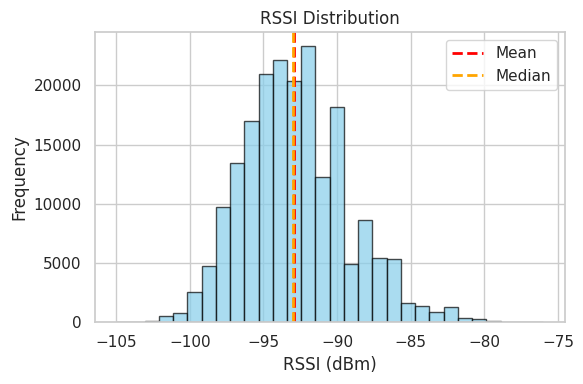

In [15]:
# Cell 14: Plot - RSSI Distribution (Target)
if 'subset' in globals():
    plot_name = "RSSI Distribution"
    plot_params = {
        "mean": float(subset['RSSI'].mean()),
        "median": float(subset['RSSI'].median()),
        "samples": int(len(subset)),
    }
    data_notes = {
        "quartiles": {
            "q25": float(subset['RSSI'].quantile(0.25)),
            "q75": float(subset['RSSI'].quantile(0.75)),
        }
    }
    print("Params:", plot_params)
    plt.figure(figsize=(6, 4))
    plt.hist(subset['RSSI'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(subset['RSSI'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    plt.axvline(subset['RSSI'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
    plt.xlabel("RSSI (dBm)")
    plt.ylabel("Frequency")
    plt.title(plot_name)
    plt.legend()
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Phân phối RSSI cho location/beacon mục tiêu",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 12 first.")

Params: {'median_gap_sec': 0.005, 'mean_gap_sec': 0.051245305140387006, 'count': 196172}
[PLOT LOG] Time Gap Distribution (<60s)
{
  "name": "Time Gap Distribution (<60s)",
  "description": "Phân phối khoảng cách thời gian đo RSSI (<60s)",
  "params": {
    "median_gap_sec": 0.005,
    "mean_gap_sec": 0.051245305140387006,
    "count": 196172
  },
  "data_notes": {
    "max_gap_sec": 56.805
  },
  "timestamp": "2025-12-09T15:00:45.963398"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


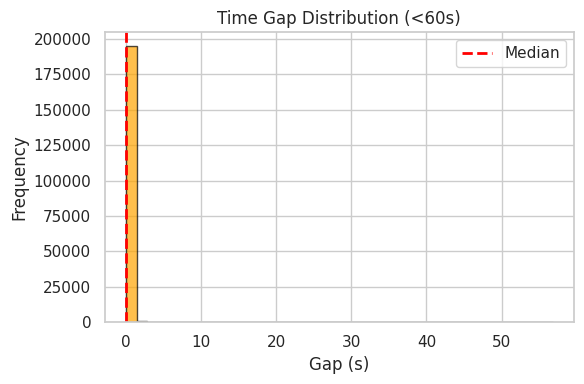

In [16]:
# Cell 15: Plot - Time Gap Distribution (<60s)
if 'gaps' in globals():
    gaps_filtered = gaps[gaps < 60]
    plot_name = "Time Gap Distribution (<60s)"
    plot_params = {
        "median_gap_sec": float(gaps_filtered.median()),
        "mean_gap_sec": float(gaps_filtered.mean()),
        "count": int(len(gaps_filtered)),
    }
    data_notes = {
        "max_gap_sec": float(gaps_filtered.max()) if len(gaps_filtered) else None,
    }
    print("Params:", plot_params)
    plt.figure(figsize=(6, 4))
    plt.hist(gaps_filtered, bins=40, color='orange', edgecolor='black', alpha=0.7)
    plt.axvline(gaps_filtered.median(), color='red', linestyle='--', linewidth=2, label='Median')
    plt.xlabel("Gap (s)")
    plt.ylabel("Frequency")
    plt.title(plot_name)
    plt.legend()
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="Phân phối khoảng cách thời gian đo RSSI (<60s)",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 12 first.")

Params: {'beacon': '9', 'locations': 5}
[PLOT LOG] RSSI Distribution Across Locations (Beacon 9)
{
  "name": "RSSI Distribution Across Locations (Beacon 9)",
  "description": "So sánh phân phối RSSI theo location cho beacon mục tiêu",
  "params": {
    "beacon": "9",
    "locations": 5
  },
  "data_notes": {
    "samples_per_location": {
      "nurse station": 196245,
      "cafeteria": 25855,
      "hallway": 5793,
      "kitchen": 4300,
      "cleaning": 3531
    }
  },
  "timestamp": "2025-12-09T15:00:46.876947"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


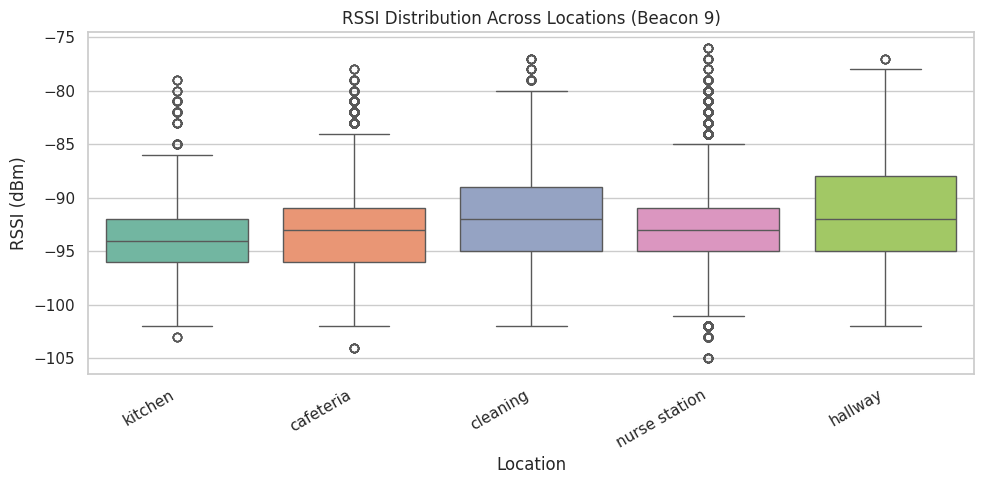

In [17]:
# Cell 16: Plot - RSSI Boxplot Across Locations (Target Beacon)
if 'subset_multi' in globals():
    plot_name = f"RSSI Distribution Across Locations (Beacon {TARGET_BEACON})"
    plot_params = {
        "beacon": TARGET_BEACON,
        "locations": int(subset_multi['location'].nunique()),
    }
    data_notes = {
        "samples_per_location": subset_multi['location'].value_counts().head(5).to_dict(),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=subset_multi, x='location', y='RSSI', palette="Set2")
    plt.xlabel("Location")
    plt.ylabel("RSSI (dBm)")
    plt.title(plot_name)
    plt.xticks(rotation=30, ha='right')
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="So sánh phân phối RSSI theo location cho beacon mục tiêu",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 12 first.")

Params: {'snr_threshold': 5, 'locations': ['nurse station', 'cafeteria', 'kitchen', 'cleaning', 'hallway']}
[PLOT LOG] SNR Comparison (Beacon 9)
{
  "name": "SNR Comparison (Beacon 9)",
  "description": "So sánh SNR giữa các location cho beacon mục tiêu",
  "params": {
    "snr_threshold": 5,
    "locations": [
      "nurse station",
      "cafeteria",
      "kitchen",
      "cleaning",
      "hallway"
    ]
  },
  "data_notes": {
    "snr_list": [
      25.19,
      23.98,
      23.26,
      18.98,
      18.92
    ]
  },
  "timestamp": "2025-12-09T15:00:47.184555"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


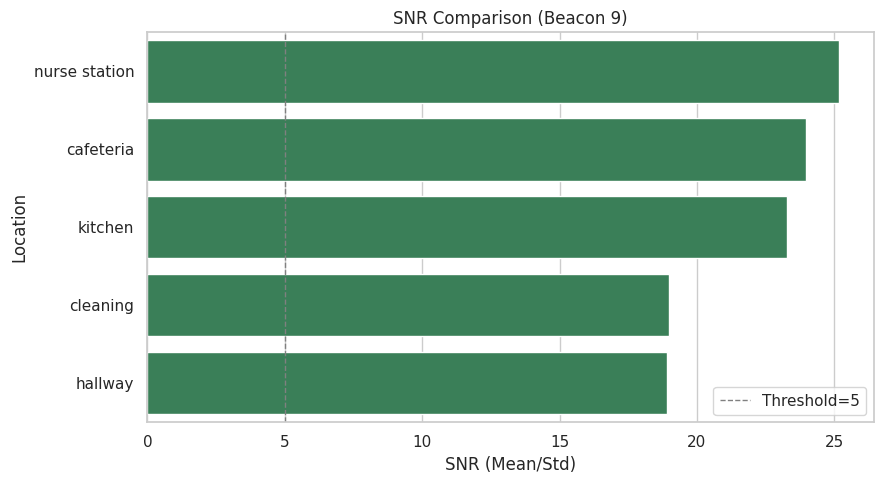

In [18]:
# Cell 17: Plot - SNR Comparison (Target Beacon)
if 'df_loc_stats' in globals():
    plot_name = f"SNR Comparison (Beacon {TARGET_BEACON})"
    plot_params = {
        "snr_threshold": 5,
        "locations": df_loc_stats['location'].tolist(),
    }
    data_notes = {
        "snr_list": df_loc_stats['snr'].round(2).tolist(),
    }
    print("Params:", plot_params)
    plt.figure(figsize=(9, 5))
    sns.barplot(y=df_loc_stats['location'], x=df_loc_stats['snr'], color='seagreen')
    plt.axvline(5, color='gray', linestyle='--', linewidth=1, label='Threshold=5')
    plt.xlabel("SNR (Mean/Std)")
    plt.ylabel("Location")
    plt.title(plot_name)
    plt.legend()
    plt.gcf().subplots_adjust(left=0.3)
    plt.tight_layout()
    log_plot(
        name=plot_name,
        description="So sánh SNR giữa các location cho beacon mục tiêu",
        params=plot_params,
        data_notes=data_notes,
    )
    plt.show()
else:
    print("Run Cell 12 first.")

In [19]:
# Cell 18: Feature Engineering - Sliding Window Aggregation
# Khử nhiễu và tạo features ổn định hơn bằng Sliding Window.

if 'df_final' in locals():
    print("Running Sliding Window (window=5s)")

    WINDOW_SIZE = '5s'
    windowed_list = []

    for loc in tqdm(sorted(df_final['location'].unique()), desc="Processing Locations"):
        df_loc = df_final[df_final['location'] == loc].copy()
        df_loc = df_loc.groupby(['datetime', 'beacon_id'], as_index=False)['RSSI'].mean()
        df_pivot = df_loc.pivot(index='datetime', columns='beacon_id', values='RSSI')
        df_resampled = df_pivot.resample(WINDOW_SIZE).mean()
        df_resampled = df_resampled.dropna(how='all')
        df_resampled = df_resampled.fillna(-100)
        df_resampled = df_resampled.reset_index(drop=True)
        df_resampled['location'] = loc
        windowed_list.append(df_resampled)

    df_windowed = pd.concat(windowed_list, ignore_index=True)

    for b_id in BEACON_IDS:
        if b_id not in df_windowed.columns:
            df_windowed[b_id] = -100

    df_windowed = df_windowed.fillna(-100)
    cols_ordered = sorted([c for c in df_windowed.columns if c != 'location'], key=lambda x: int(x)) + ['location']
    df_windowed = df_windowed[cols_ordered]

    print("Feature Engineering DONE")
    print(f"Shape: {df_windowed.shape}")
    display(df_windowed.head(5))

    print("\nFEATURE ENGINEERING REPORT")
    print(f"Original Raw Samples: {len(df_final):,}")
    print(f"Windowed Samples (5s): {len(df_windowed):,}")
    print(f"Compression Ratio: {len(df_final)/len(df_windowed):.1f}x")
    print(f"NaN Count: {df_windowed.isna().sum().sum()}")
    print(f"All 25 Beacons Present: {len([c for c in df_windowed.columns if c != 'location']) == 25}")
    print(f"Locations: {df_windowed['location'].nunique()}")
else:
    print("Run Cell 2 first.")

Running Sliding Window (window=5s)


Processing Locations: 100%|██████████| 22/22 [00:03<00:00,  7.33it/s]

Feature Engineering DONE
Shape: (6093, 26)


beacon_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,location
0,-90.962963,-100.0,-100.0,-100.0,-97.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-88.0,-100.0,-90.666667,-93.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100,-100,501
1,-100.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100,-100,501
2,-100.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-99.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100,-100,501
3,-98.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100,-100,501
4,-96.500000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-98.0,-100.0,-96.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100,-100,501



FEATURE ENGINEERING REPORT
Original Raw Samples: 1,117,361
Windowed Samples (5s): 6,093
Compression Ratio: 183.4x
NaN Count: 0
All 25 Beacons Present: True
Locations: 22


Advanced Feature Analysis...
Params: corr_matrix shape (25, 25)
[PLOT LOG] Beacon Correlation Matrix
{
  "name": "Beacon Correlation Matrix",
  "description": "Ma trận tương quan giữa các beacon",
  "params": {
    "rows": 25,
    "cols": 25
  },
  "data_notes": {
    "sample_corr": {
      "1": {
        "1": 1.0,
        "2": 0.48,
        "3": 0.41
      },
      "2": {
        "1": 0.48,
        "2": 1.0,
        "3": 0.72
      },
      "3": {
        "1": 0.41,
        "2": 0.72,
        "3": 1.0
      }
    }
  },
  "timestamp": "2025-12-09T15:00:51.518398"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


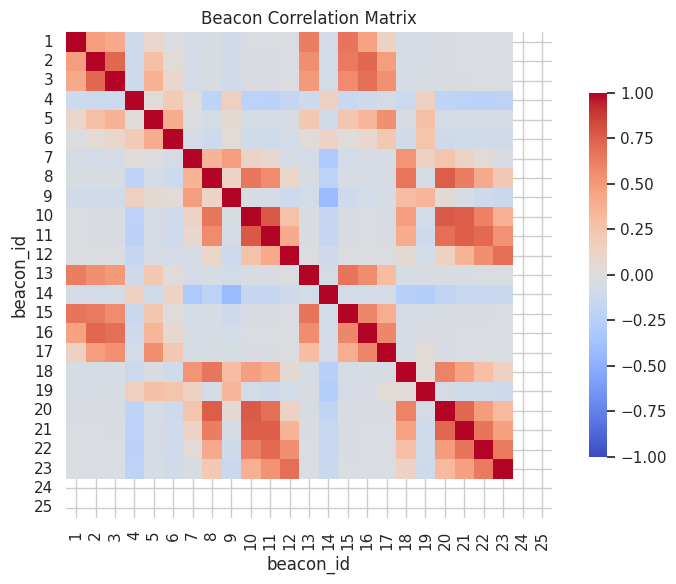

Params: top5 variances=[16.09, 15.73, 12.96, 10.46, 7.78]
[PLOT LOG] Beacon Variance
{
  "name": "Beacon Variance",
  "description": "Phương sai theo beacon sau resample",
  "params": {
    "top5_variances": [
      16.09,
      15.73,
      12.96,
      10.46,
      7.78
    ]
  },
  "data_notes": {
    "bottom5_variances": [
      0.88,
      0.85,
      0.63,
      0.0,
      0.0
    ]
  },
  "timestamp": "2025-12-09T15:00:51.931555"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


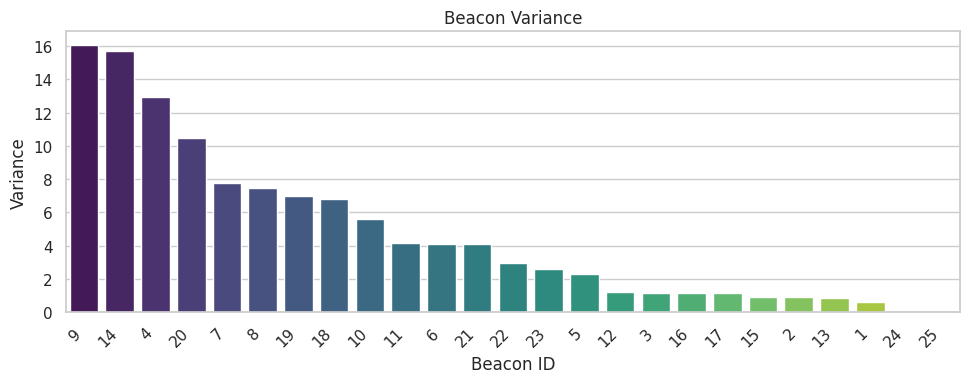

Running PCA...
[PLOT LOG] PCA Scatter (2D)
{
  "name": "PCA Scatter (2D)",
  "description": "PCA 2D sau chuẩn hóa StandardScaler",
  "params": {
    "explained_total": 0.43318719260669347,
    "pc1": 0.23872906727236196,
    "pc2": 0.19445812533433152
  },
  "data_notes": {
    "num_samples": 6093,
    "num_locations": 22
  },
  "timestamp": "2025-12-09T15:00:52.134934"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


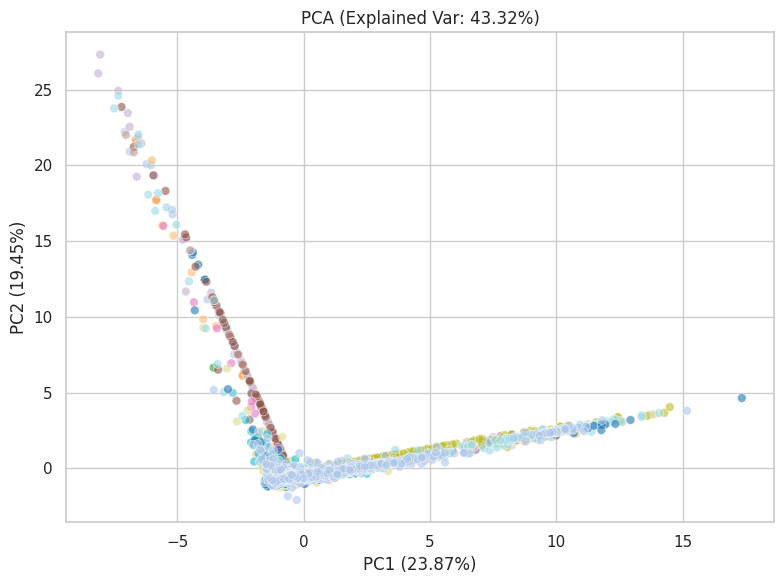

Running t-SNE...
[PLOT LOG] t-SNE (Manifold Structure)
{
  "name": "t-SNE (Manifold Structure)",
  "description": "t-SNE 2D để quan sát manifold",
  "params": {
    "perplexity": 30,
    "samples": 6093
  },
  "data_notes": {
    "num_locations": 22
  },
  "timestamp": "2025-12-09T15:01:07.696530"
}
[PLOT LOG] Đã lưu: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata.json


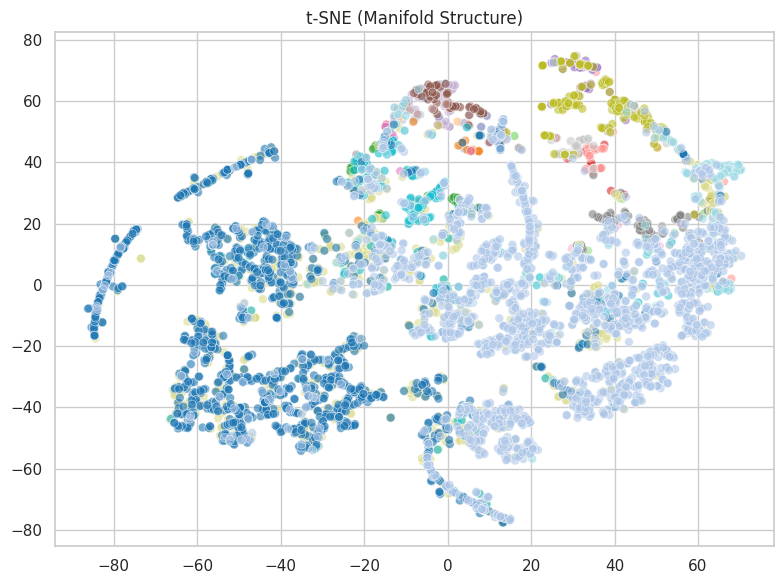

ANALYSIS SUMMARY
High-corr pairs (>0.8): 0
Low-variance beacons (<10): ['7', '8', '19', '18', '10', '11', '6', '21', '22', '23', '5', '12', '3', '16', '17', '15', '2', '13', '1', '24', '25']
PCA explained variance: 43.32%


In [20]:
# Cell 19: Advanced Feature Analysis (PCA, t-SNE, Correlation)
# Đánh giá khả năng phân tách dữ liệu sau Feature Engineering.

if 'df_windowed' in locals():
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler

    print("Advanced Feature Analysis...")

    feature_cols = [c for c in df_windowed.columns if c != 'location']
    X = df_windowed[feature_cols]
    y = df_windowed['location']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Plot 1: Correlation Matrix
    corr_matrix = X.corr()
    plot_name_corr = "Beacon Correlation Matrix"
    plot_params_corr = {
        "rows": int(corr_matrix.shape[0]),
        "cols": int(corr_matrix.shape[1]),
    }
    data_notes_corr = {
        "sample_corr": corr_matrix.iloc[:3, :3].round(2).to_dict(),
    }
    print("Params: corr_matrix shape {}".format(corr_matrix.shape))
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.75})
    plt.title(plot_name_corr)
    plt.tight_layout()
    log_plot(
        name=plot_name_corr,
        description="Ma trận tương quan giữa các beacon",
        params=plot_params_corr,
        data_notes=data_notes_corr,
    )
    plt.show()

    # Plot 2: Variance per Beacon
    variances = X.var().sort_values(ascending=False)
    plot_name_var = "Beacon Variance"
    plot_params_var = {
        "top5_variances": variances.head(5).round(2).tolist(),
    }
    data_notes_var = {
        "bottom5_variances": variances.tail(5).round(2).tolist(),
    }
    print("Params: top5 variances={}".format(variances.head(5).round(2).tolist()))
    plt.figure(figsize=(10, 4))
    sns.barplot(x=variances.index, y=variances.values, palette='viridis')
    plt.ylabel('Variance')
    plt.xlabel('Beacon ID')
    plt.xticks(rotation=45, ha='right')
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.title(plot_name_var)
    plt.tight_layout()
    log_plot(
        name=plot_name_var,
        description="Phương sai theo beacon sau resample",
        params=plot_params_var,
        data_notes=data_notes_var,
    )
    plt.show()

    # Plot 3: PCA scatter
    print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_total = float(pca.explained_variance_ratio_.sum())
    plot_name_pca = "PCA Scatter (2D)"
    plot_params_pca = {
        "explained_total": explained_total,
        "pc1": float(pca.explained_variance_ratio_[0]),
        "pc2": float(pca.explained_variance_ratio_[1]),
    }
    data_notes_pca = {
        "num_samples": int(len(X_scaled)),
        "num_locations": int(y.nunique()),
    }
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='tab20', s=40, alpha=0.6, legend=False)
    plt.title(f'PCA (Explained Var: {explained_total:.2%})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.tight_layout()
    log_plot(
        name=plot_name_pca,
        description="PCA 2D sau chuẩn hóa StandardScaler",
        params=plot_params_pca,
        data_notes=data_notes_pca,
    )
    plt.show()

    # Plot 4: t-SNE scatter
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
    X_tsne = tsne.fit_transform(X_scaled)
    plot_name_tsne = "t-SNE (Manifold Structure)"
    plot_params_tsne = {
        "perplexity": 30,
        "samples": int(len(X_scaled)),
    }
    data_notes_tsne = {
        "num_locations": int(y.nunique()),
    }
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='tab20', s=40, alpha=0.6, legend=False)
    plt.title(plot_name_tsne)
    plt.tight_layout()
    log_plot(
        name=plot_name_tsne,
        description="t-SNE 2D để quan sát manifold",
        params=plot_params_tsne,
        data_notes=data_notes_tsne,
    )
    plt.show()

    # Report
    high_corr_pairs = []
    corr_mat_abs = corr_matrix.abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_mat_abs.iloc[i, j] > 0.8:
                high_corr_pairs.append(f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]} ({corr_matrix.iloc[i, j]:.2f})")

    low_var_beacons = variances[variances < 10].index.tolist()

    print("ANALYSIS SUMMARY")
    print(f"High-corr pairs (>0.8): {len(high_corr_pairs)}")
    if high_corr_pairs:
        print(f"Examples: {', '.join(high_corr_pairs[:5])}")
    print(f"Low-variance beacons (<10): {low_var_beacons}")
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
else:
    print("Run Cell 18 first.")